This is the master script for learning the Q function and improving the policy

Operates on the linearised, multiagent system

u=Kx
noisy controller
uses u_next = Kx for the phi(U_next)


In [1]:
import numpy as np
import pdb
import matplotlib.pyplot as plt
import time
import math


#####################################

class ThreeVehicles():
    
    def __init__(self,K,noisy_model = False, noisy_controller=False):
        
        ###############################################
        #Define all physical constants needed for model
        ###############################################
        
        self.Aa = 20
        self.Cd = 0.6
        self.Cr = 0.005
        self.rho = 1.2
        self.Je = 10
        self.Jw=3
        self.r_w = 0.6
        self.trans_ratio = 1
        self.efficiency = 0.9
        self.m = 30000
        self.g = 9.81
        
        # Create constants to make the model much simpler
        self.K_denominator = self.Jw + (self.m*self.r_w**2) + self.trans_ratio**2 * self.efficiency * self.Je

        self.K1 = self.r_w * self.trans_ratio * self.efficiency /self.K_denominator
        self.K2 = (0.5 * self.Aa * self.rho * self.Cd * self.r_w**2)/self.K_denominator
        self.K3 = (self.Cr*self.m*self.g*self.r_w**2)/self.K_denominator
        self.K4 = (self.m*self.g*self.r_w**2)/self.K_denominator

        # Define coefficients of f_i(d) - the approximation for the non linear equation giving reduction in drag
        self.w1=-0.9379
        self.w2=-0.4502
        self.w3=-0.43735

        self.eps1=12.896
        self.eps2=43.0046
        self.eps3=51.5027


        # Define SAMPLING TIME for discretisation
        # 50ms
        self.Ts = 5e-2

        #########################
        # Define equilibrium point
        #########################
        
        self.v0 = 25
        self.Tau_ref = 0.4  # Time gap between vehicles at steady state
        # d0 MUST REMAIN WITHIN THE RANGE OF THE LINEAR APPROX FOR DRAG REDUCTION (ie less than 15m)
        self.d0 = self.Tau_ref * self.v0 # 25*0.4 = 10
        self.alpha0=0 # slope of road (assume 0 slope for now)
        
        ######################
        #T0 values are: [3875.49 2825.92 2567.12]

        self.T01 = (self.K2 * (1-0.01*(self.w1*self.d0+self.eps1)) * self.v0**2 + self.K3*np.cos(self.alpha0) + self.K4*np.sin(self.alpha0))/self.K1
        self.T02 = (self.K2 * (1-0.01*(self.w2*self.d0+self.eps2)) * self.v0**2 + self.K3*np.cos(self.alpha0) + self.K4*np.sin(self.alpha0))/self.K1
        self.T03 = (self.K2 * (1-0.01*(self.w3*self.d0+self.eps3)) * self.v0**2 + self.K3*np.cos(self.alpha0) + self.K4*np.sin(self.alpha0))/self.K1

        
        ############################
        # Build A and B matrices for linearised model
        ############################

        self.A_v1 = [1-2*self.Ts*self.K2*(1-0.01*(self.w1*self.d0+self.eps1)), self.Ts*self.K2*0.01*self.w1*self.v0**2 , 0 , 0 , 0]
        self.A_d12 = [self.Ts, 1, -self.Ts, 0, 0]
        self.A_v2 = [0, self.Ts*self.K2*0.01*self.w2*self.v0**2 , 1-2*self.Ts*self.K2*(1-0.01*(self.w2*self.d0+self.eps2)), 0 , 0 ]
        self.A_d23 = [0, 0, self.Ts, 1, -self.Ts]
        self.A_v3 = [0, 0, 0, self.Ts*self.K2*0.01*self.w3*self.v0**2 , 1-2*self.Ts*self.K2*(1-0.01*(self.w3*self.d0+self.eps3)) ]

        self.A = np.array([self.A_v1,self.A_d12,self.A_v2,self.A_d23,self.A_v3])
        self.B = 10e+4 * np.array([[self.Ts*self.K1,0,0],[0,0,0],[0,self.Ts*self.K1,0],[0,0,0],[0,0,self.Ts*self.K1]])
        
        ###################
        # Define Cost Matrices
        ###################
        
        #Q1, Q2, Q3 punish v1,v2,v3**2 for each vehicle
        #Q4,Q5 punish the time gap for each vehicle given by: (d12 - Tau_ref * v_following)
        # R1,R2,R3 punish the difference on torque from the reference (HOW to make -ve torque have lower cost)
        self.Q1 = 0.05
        self.Q2 = 0.05
        self.Q3 = 0.05
        self.Q4 = .1
        self.Q5 = .1
        self.R1 = 100
        self.R2 = 100
        self.R3 = 100
        
        self.Q = np.array([[self.Q1, 0, 0, 0, 0],
                           [0, self.Q4, -self.Tau_ref * self.Q4, 0, 0],
                           [0, -self.Tau_ref * self.Q4, self.Q2 + self.Tau_ref**2 * self.Q4, 0, 0],
                           [0,0,0,self.Q5,-self.Tau_ref*self.Q5],
                           [ 0,0,0,-self.Tau_ref * self.Q5, self.Q3 + self.Tau_ref**2 * self.Q5 ]])
        
        
        self.R = np.array([[self.R1,0,0],
                         [0,self.R1,0],
                         [0,0,self.R1]])        
        
        self.disc_fact=0.99
        
        ################
        # Define Gain Matrix (input)
        ################
        
        self.K = K
        
        # st dev of the model noise
        
        if noisy_model == True:
            self.sigma_model = 0.2
        else:
            self.sigma_model = 0
        
        #st dev of the controller noise: u = kx + noise
        self.sigma_controller = 0.25
        self.noisy_controller = noisy_controller
        
    def GetPolicyInput(self,x):
        #For a given state, return the input u according to a defined policy
        # x: 5x1 array
        
        inp = np.matmul(self.K,x).reshape(3,1)
        
        if self.noisy_controller:
            inp += self.GetControllerNoise()
        
        # 3x1 array
        return inp
    
    def GetControllerNoise(self):
        
        contr_noise = self.sigma_controller * np.random.randn(3,1)
        
        return contr_noise
    
    def GetCost(self, x, u):
        #For a given state and input, return the one step cost of this new state
        # x: 5x1 array
        # u: 3x1 array
        
        # x'Ex
        cost1 = np.matmul(np.matmul(x.transpose(),self.Q),x)
        
        # u'Fu
        cost2 = np.matmul(np.matmul(u.transpose(),self.R),u)
        
        
        #scalar
        return (cost1+cost2)[0][0]
    
    def GetNoise(self): #model
        #Returns a vector of noise for the 1st,3rd, and 5th states
        # Noise is necessary for the exploration
        
        w = self.sigma_model * np.array([np.random.randn(1)[0],0,np.random.randn(1)[0],0,np.random.randn(1)[0]]).reshape(5,1)
        
        # 5x1 array
        return w
    
    def GetNextState(self,x,u):
        #x_next = Ax + Bu  (+noise)
        # x: 5x1 array
        # u: 3x1 array
            
        
        x_next_1 = np.matmul(self.A,x)
        x_next_2 = np.matmul(self.B,u)
        x_next_3 = self.GetNoise()
       
        x_next = x_next_1 + x_next_2 + x_next_3
        
        # 5x1 array
        return x_next
    
    def RunEpisode(self,ep_length,state_initial):
        
        #function will carry out an episode of transitions given an initial state vector
        #It will return lists of the states, costs of each transition and inputs
        
        # Format:
        #  ep_length: integer
        #  state_initial: list e.g. [1,2,3,4,5]
        
        
        x = np.array(state_initial).reshape(5,1)
        
        ALL_state_list = [x]
        cost_list = []
        input_list = []
        
        for k in range(ep_length):
            
            u = self.GetPolicyInput(x)
            
            #pdb.set_trace()
            
            input_list.append(u)
            x = self.GetNextState(x,u)
            
            cost = self.GetCost(x,u)
            
            ALL_state_list.append(x)
            cost_list.append(cost)
        
        # ALL_state_list is a list where each element is a 5x1 array
        # cost_list is a list where each element is a scalar
        # input_list is a list where each element is a 3x1 array
        # length of all lists = ep_length
        return ALL_state_list, cost_list, input_list
    
    def ExtractStates(self, states_list):
        # takes in the list of all states and returns individual lists for each state
        # states_list: list of arrays, each array is 5x1
        
        v1 = []
        d12 = []
        v2 = []
        d23 = []
        v3 = []
        
        for i,item in enumerate(states_list):
            
            v1.append(states_list[i][0][0])
            d12.append(states_list[i][1][0])
            v2.append(states_list[i][2][0])
            d23.append(states_list[i][3][0])
            v3.append(states_list[i][4][0])

        # 5 lists of numbers
        # each list is the length of the episode
        return v1,d12,v2,d23,v3
    
    def ExtractInputs(self,input_list):
        # Takes in the list of all the inputs and returns individual lists for each input
        # input_list: list of arrays, each array is 3x1
        
        u1 = []
        u2 = []
        u3 = []
        
        for i,item in enumerate(input_list):
            
            u1.append(input_list[i][0][0])
            u2.append(input_list[i][1][0])
            u3.append(input_list[i][2][0])
            
        # 3 lists of numbers
        # each list is as long as the episode
        return u1,u2,u3
    
    def LSOptimiser(self,number_of_episodes=10,episode_length=50):
        # This function carries out the LS estimation of the value function. It runs a certain number of iterations, then uses the LS algorithm to estimate the action value function 
        # There are 36 states and a constant term 
        # Try with the 37 but will likely cause problems
        #######
        # It will return an array called Theta which correspond to these 37 coefficients
        
        # These are the lists that contains lists of each episodes
        V1_Matrix_list = []
        V2_Matrix_list = []
        V3_Matrix_list = []
        D12_Matrix_list = []
        D23_Matrix_list = []
        
        U1_Matrix_list = []
        U2_Matrix_list = []
        U3_Matrix_list = []
        
        Costs_Matrix_list = []
        
        ############################
        # Define variance for initial states
        # Don't want initial distance to be negative
        ###################################
        sigma_v1 = 10
        sigma_v2 = 10
        sigma_v3 = 10
        sigma_d12 = 5
        sigma_d23 = 5
        
        def GetRandomInitialState():
        #returns a random initial state
            v1_in = sigma_v1 * np.random.randn(1)[0]
            v2_in = sigma_v1 * np.random.randn(1)[0]
            v3_in = sigma_v1 * np.random.randn(1)[0]
            
            d12_in = 5+sigma_d12 * np.random.randn(1)[0]
            d23_in = 5+sigma_d23 * np.random.randn(1)[0]
            
        
            return [v1_in,d12_in,v2_in,d23_in,v3_in]
        
        for episode in range(number_of_episodes):
            
            if episode%1000==0:
                print(f"...running. Episode {episode} complete, {number_of_episodes-episode} episodes remaining")
            
            X_initial = GetRandomInitialState()
            
            SL, CL, IL = self.RunEpisode(episode_length,X_initial)
            
            v1,d12,v2,d23,v3 = self.ExtractStates(SL)
            u1,u2,u3 = self.ExtractInputs(IL)
            
            V1_Matrix_list.append(v1)
            V2_Matrix_list.append(v2)
            V3_Matrix_list.append(v3)
            D12_Matrix_list.append(d12)
            D23_Matrix_list.append(d23)

            U1_Matrix_list.append(u1)
            U2_Matrix_list.append(u2)
            U3_Matrix_list.append(u3)

            Costs_Matrix_list.append(CL)
            
        # Now we have a list of lists for each of the states, inputs and costs
        
        # Each list contains p episodes
        # Each episode contains k transitions and k+1 states
        # There are therefore p*k transitions in total = N
        
        N = 0
        
        for episode in Costs_Matrix_list:
            N += len(episode)
            
        Beta_k = np.zeros((37,N))
        Beta_kplus1 = np.zeros((37,N))
        C_k = np.zeros((N)).reshape(N,1)
        
        transition_counter = 0
        
        print(f'...populating LS Matrices')
        
        # for each transition, we can create an equation and hence populate a column of our matrices
        
        for idx_episode,episode in enumerate(Costs_Matrix_list):
            for idx_transition,transition in enumerate(episode):
                
                v1_k = V1_Matrix_list[idx_episode][idx_transition]
                v1_knext = V1_Matrix_list[idx_episode][idx_transition+1]
                
                v2_k = V2_Matrix_list[idx_episode][idx_transition]
                v2_knext = V2_Matrix_list[idx_episode][idx_transition+1]
                
                v3_k = V3_Matrix_list[idx_episode][idx_transition]
                v3_knext = V3_Matrix_list[idx_episode][idx_transition+1]
            
                d12_k = D12_Matrix_list[idx_episode][idx_transition]
                d12_knext = D12_Matrix_list[idx_episode][idx_transition+1]
                
                d23_k = D23_Matrix_list[idx_episode][idx_transition]
                d23_knext = D23_Matrix_list[idx_episode][idx_transition+1]
                
                u1_k = U1_Matrix_list[idx_episode][idx_transition]
                u2_k = U2_Matrix_list[idx_episode][idx_transition]
                u3_k = U3_Matrix_list[idx_episode][idx_transition]
                
                x_next_vector = np.array([v1_knext, d12_knext, v2_knext, d23_knext,v3_knext]).reshape(5,1)
                input_next = np.matmul(self.K,x_next_vector)
                
                u1_knext = input_next[0][0]
                u2_knext = input_next[1][0]
                u3_knext = input_next[2][0]
                
                trans_cost = Costs_Matrix_list[idx_episode][idx_transition]
        
            ##########################################################    
            #Populate Beta_k matrix
                #
                Beta_k[0][transition_counter] = v1_k * v1_k
                #
                Beta_k[1][transition_counter] = v1_k * v2_k
                #
                Beta_k[2][transition_counter] = v1_k * v3_k
                #
                Beta_k[3][transition_counter] = v1_k * d12_k
                #
                Beta_k[4][transition_counter] = v1_k * d23_k
                #
                Beta_k[5][transition_counter] = v1_k * u1_k
                #
                Beta_k[6][transition_counter] = v1_k * u2_k
                                #
                Beta_k[7][transition_counter] = v1_k * u3_k
                #
                Beta_k[8][transition_counter] = v2_k * v2_k
                #
                Beta_k[9][transition_counter] = v2_k * v3_k
                #
                Beta_k[10][transition_counter] = v2_k * d12_k
                #
                Beta_k[11][transition_counter] = v2_k * d23_k
                #
                Beta_k[12][transition_counter] = v2_k * u1_k
                #
                Beta_k[13][transition_counter] = v2_k * u2_k
                                #
                Beta_k[14][transition_counter] = v2_k * u3_k
                #
                Beta_k[15][transition_counter] = v3_k * v3_k
                #
                Beta_k[16][transition_counter] = v3_k * d12_k
                #
                Beta_k[17][transition_counter] = v3_k * d23_k
                #
                Beta_k[18][transition_counter] = v3_k * u1_k
                #
                Beta_k[19][transition_counter] = v3_k * u2_k
                #
                Beta_k[20][transition_counter] = v3_k * u3_k
                                #
                Beta_k[21][transition_counter] = d12_k * d12_k
                #
                Beta_k[22][transition_counter] = d12_k * d23_k
                #
                Beta_k[23][transition_counter] = d12_k * u1_k
                #
                Beta_k[24][transition_counter] = d12_k * u2_k
                #
                Beta_k[25][transition_counter] = d12_k * u3_k
                #
                Beta_k[26][transition_counter] = d23_k * d23_k
                #
                Beta_k[27][transition_counter] = d23_k * u1_k
                                #
                Beta_k[28][transition_counter] = d23_k * u2_k
                #
                Beta_k[29][transition_counter] = d23_k * u3_k
                #
                Beta_k[30][transition_counter] = u1_k * u1_k
                #
                Beta_k[31][transition_counter] = u1_k * u2_k
                #
                Beta_k[32][transition_counter] = u1_k * u3_k
                #
                Beta_k[33][transition_counter] = u2_k * u2_k
                #
                Beta_k[34][transition_counter] = u2_k * u3_k
                #
                Beta_k[35][transition_counter] = u3_k * u3_k
                #
                Beta_k[36][transition_counter] = 1
                
                #############################################
                #Populate Beta_k matrix
                #
                Beta_kplus1[0][transition_counter] = v1_knext * v1_knext * self.disc_fact
                #
                Beta_kplus1[1][transition_counter] = v1_knext * v2_knext * self.disc_fact
                #
                Beta_kplus1[2][transition_counter] = v1_knext * v3_knext * self.disc_fact
                #
                Beta_kplus1[3][transition_counter] = v1_knext * d12_knext * self.disc_fact
                #
                Beta_kplus1[4][transition_counter] = v1_knext * d23_knext * self.disc_fact
                #
                Beta_kplus1[5][transition_counter] = v1_knext * u1_knext * self.disc_fact
                #
                Beta_kplus1[6][transition_counter] = v1_knext * u2_knext * self.disc_fact
                                #
                Beta_kplus1[7][transition_counter] = v1_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[8][transition_counter] = v2_knext * v2_knext * self.disc_fact
                #
                Beta_kplus1[9][transition_counter] = v2_knext * v3_knext * self.disc_fact
                #
                Beta_kplus1[10][transition_counter] = v2_knext * d12_knext * self.disc_fact
                #
                Beta_kplus1[11][transition_counter] = v2_knext * d23_knext * self.disc_fact
                #
                Beta_kplus1[12][transition_counter] = v2_knext * u1_knext * self.disc_fact
                #
                Beta_kplus1[13][transition_counter] = v2_knext * u2_knext * self.disc_fact
                                #
                Beta_kplus1[14][transition_counter] = v2_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[15][transition_counter] = v3_knext * v3_knext * self.disc_fact
                #
                Beta_kplus1[16][transition_counter] = v3_knext * d12_knext * self.disc_fact
                #
                Beta_kplus1[17][transition_counter] = v3_knext * d23_knext * self.disc_fact
                #
                Beta_kplus1[18][transition_counter] = v3_knext * u1_knext * self.disc_fact
                #
                Beta_kplus1[19][transition_counter] = v3_knext * u2_knext * self.disc_fact
                #
                Beta_kplus1[20][transition_counter] = v3_knext * u3_knext * self.disc_fact
                                #
                Beta_kplus1[21][transition_counter] = d12_knext * d12_knext * self.disc_fact
                #
                Beta_kplus1[22][transition_counter] = d12_knext * d23_knext * self.disc_fact
                #
                Beta_kplus1[23][transition_counter] = d12_knext * u1_knext * self.disc_fact
                #
                Beta_kplus1[24][transition_counter] = d12_knext * u2_knext * self.disc_fact
                #
                Beta_kplus1[25][transition_counter] = d12_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[26][transition_counter] = d23_knext * d23_knext * self.disc_fact
                #
                Beta_kplus1[27][transition_counter] = d23_knext * u1_knext * self.disc_fact
                                #
                Beta_kplus1[28][transition_counter] = d23_knext * u2_knext * self.disc_fact
                #
                Beta_kplus1[29][transition_counter] = d23_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[30][transition_counter] = u1_knext * u1_knext * self.disc_fact
                #
                Beta_kplus1[31][transition_counter] = u1_knext * u2_knext * self.disc_fact
                #
                Beta_kplus1[32][transition_counter] = u1_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[33][transition_counter] = u2_knext * u2_knext * self.disc_fact
                #
                Beta_kplus1[34][transition_counter] = u2_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[35][transition_counter] = u3_knext * u3_knext * self.disc_fact
                #
                Beta_kplus1[36][transition_counter] = 1 * self.disc_fact
                
                #################################################
                #populate Ck
                C_k[transition_counter] = trans_cost
                
                transition_counter +=1
                
        if transition_counter != N:
            print('Error!! Matrices do not match')
        else:
            print('All Done!')
            
        # Convert to matrices of the form Ax=b
        A_mat = np.matmul(Beta_k,(Beta_k-Beta_kplus1).transpose())
        b_mat = np.matmul(Beta_k,C_k)
        
        return A_mat,b_mat
    ##########################################################
    # END of LS OPTIMISER
    ##########################################################

        ############################################
        #ALGORITHM FOR GRADIENT DESCENT SINCE MATRICES ARE TOO BIG TO SOLVE ANALYTICALLY
        ##############################################
        
        
        
    def GradDescent(self,A,b,Max_iterations = 100000, tolerance = 0.00005):
        #Takes in a matrix and a vector (formulated above) and uses gradient descent to solve for theta since in an Ax-B format


        # epsilon is the step length

        # Find the epsilon that makes it stable by cycling through smaller and smaller until the eigenvalues are all less than 1
        # In practice the eigenvalues will always be less than one so make sure they're less than 1.0000001

        Theta_size = b.shape[0]
        epsil = 0.1
        eye_size = np.identity(Theta_size)

        while True:
            grad_1=eye_size-epsil*A
            w,v = np.linalg.eig(grad_1)

            if max(abs(w)) < 1.0000001:
                break
            else:
                epsil = epsil/10

        print(f'stable epsilon found = {epsil}')
        #Initialise Theta0
        Theta0 = np.ones((Theta_size,1))
        #pdb.set_trace()

        # Define convergence tolerance
        ################################
        delta = tolerance
        ################################
        ten_percent = Max_iterations/10
        timer_done = False
        start_time = time.time()

        #Update Theta for every time step until convergence
        for t_iter in range(Max_iterations):
            
            grad = (np.matmul(A,Theta0)-b)
            
            if t_iter%ten_percent == 0 and t_iter !=0:
                print(f'...running Gradient Descent {100*t_iter/Max_iterations}% completed')
                print(f'Current maximum error = {max(abs(grad))}')
                
                if not timer_done:
                    elapsed = time.time() - start_time
                    Forecast_time_remaining = 9*elapsed
                    print(f'maximum remaining time: {round(Forecast_time_remaining/60)} minutes')
                    timer_done = True
            

            if max(abs(grad))<delta:
                break
            else:
                
                Theta0 -= epsil * grad
                
                if t_iter == Max_iterations-1:
                    print('Max iterations exceeded, check convergence!')
                    error = np.matmul(A,Theta0)-b
                    maxerror = MatrixMax(error)
                    print(f'Max Error: {maxerror}')
                    
                    
                # if we get halfway and it is pretty close, use it and carry on
                # if it's clearly diverging, use it but say it's rubbish
                if t_iter == math.floor(Max_iterations/2):
                    print('Halfway there')
                    
                    #if max(abs(grad))< (delta*20):
                    #    print(f'Within {delta*20} so breaking')
                    #    break
                    if max(abs(grad)) > 10e10:
                        print('Biggest error is >10e10. It will not converge. Breaking..')
                        break
                    else:
                        print('Error is decreasing but not quite there yet, carry on')
                        
                    
                    
                    
        print('All done!')

        return Theta0,t_iter

    def LSAnalytical(self,A,b):
        # Solves the same ATheta= b problem but using the inbuilt linalg solver
        
        Theta = np.linalg.solve(A,b)

        return Theta


    def PolicyMaximiser(self,Theta):
        #Given an estimation, Theta of the Q function, this will minimise over the action to space to find the optimal gains
        # It requires solving 3 simultaneous equations
        
        #The new K matrix ( for u = Kx) is found solving this:
        
        Matr1 = -np.array([[2*Theta[30][0],Theta[31][0],Theta[32][0]],
                         [Theta[31][0], 2*Theta[33][0], Theta[34][0]],
                         [Theta[32][0], Theta[34][0],2*Theta[35][0]]])
        Matr2 = np.array([[Theta[5][0],Theta[23][0],Theta[12][0],Theta[27][0],Theta[18][0]],
                         [Theta[6][0],Theta[24][0],Theta[13][0],Theta[28][0],Theta[19][0]],
                         [Theta[7][0],Theta[25][0],Theta[14][0],Theta[29][0],Theta[20][0]]])
        
        new_K = np.linalg.solve(Matr1, Matr2)
        
        #pdb.set_trace()
        
        #array of 3x5
        return new_K
        
    
    
    def RecentreVel(self,vel_list):
        #recentres a velocity list by adding 25 to each element (since linearised around 25)
        # vel_list: a LIST of scalars (not arrays) - these are the values of a particular state, not all states
    
        for i,item in enumerate(vel_list):
    
            vel_list[i]+= 25
        
        return vel_list

    def RecentreDist(self,dist_list):
        #recentres a distance list by adding 10 to each element (since linearised around 10)
        # dist_list: a LIST of scalars (not arrays) - these are the values of a particular state, not all states
    
        for i,item in enumerate(dist_list):
    
            dist_list[i]+= 10
        
        return dist_list
        
        
    def ConstructPositionVectors(self,states_list):
        # Takes in the list of ALL states and returns lists of vehicles' positions for the 3 vehicles (since d are intervehicle distances)
        # assumes all vehicles are points and do not have a size
        
        v1,d12,v2,d23,v3 = self.ExtractStates(states_list)
        
        # Recentre all states about 25 (by adding 25 to each element)
        v1_rc = self.RecentreVel(v1)
        v2_rc = self.RecentreVel(v2)
        v3_rc = self.RecentreVel(v3)
        d12_rc = self.RecentreDist(d12)
        d23_rc = self.RecentreDist(d23)
        
        
        s1 = [d23_rc[0]+d12_rc[0]]
        s2 = [d23_rc[0]]
        s3 = [0]
        
        for i in range(len(d12_rc)):
            
            if i ==0:
                pass
            
            s3.append(s3[-1]+v3_rc[i-1]*self.Ts)
            s2.append(s2[-1]+v2_rc[i-1]*self.Ts)
            s1.append(s1[-1]+v1_rc[i-1]*self.Ts)
            
        return s1,s2,s3
    
    def PlotResult(self,v1,v2,v3,d12,d23,u1,u2,u3,costs,figname,K_name,noisy_controller,model_noise,save = False):
        # Takes in the extracted states for all 5 states and plots and saves the figure
        # figname, K_name must be strings
        # f_name and noise_name will be numbers


        fig,axes = plt.subplots(3,1,figsize=(20,10))
        #axes=fig.add_axes([0,0,0.9,0.9])
        axes1 = axes[0]
        axes2 = axes[1]
        axes3 = axes[2]

        X = range(len(v1))
        Y = range(len(u1))

        v1_recentred = self.RecentreVel(v1)
        v2_recentred = self.RecentreVel(v2)
        v3_recentred = self.RecentreVel(v3)

        d12_recentred = self.RecentreDist(d12)
        d23_recentred = self.RecentreDist(d23)


        axes1.plot(X,v1_recentred,'b',label='v1')
        axes1.plot(X,v2_recentred,'r',label='v2')
        axes1.plot(X,v3_recentred,'g',label='v3')
        axes1.set_xlabel('Time Step')
        axes1.set_ylabel('Speed')
        axes1.legend()
        axes1.set_title(f'{K_name}, noisy controller: {noisy_controller}, model noise={model_noise},cost={costs}')
        #axes1.set_ylim([15,34])

        axes2.plot(X,d12_recentred,'b',label='dist_12')
        axes2.plot(X,d23_recentred,'r',label='dist_23')
        axes2.set_xlabel('Time Step')
        axes2.set_ylabel('Inter-vehicle distance')
        axes2.legend()
        #axes2.set_ylim([8,38])

        axes3.plot(Y,u1,'b',label='u1')
        axes3.plot(Y,u2,'r',label='u2')
        axes3.plot(Y,u3,'g',label='u3')
        axes3.set_xlabel('Time Step')
        axes3.set_ylabel('Input')
        axes3.legend()
        #axes3.set_ylim([-1,1])

        if save:
            plt.savefig(f'{figname}.png')
            
    
        
    def GetDiscountedCost(self,Co_list):
        # given an input of the costs list of a trajectory, this will return the discounted cost of the trajectory
        # ie sum(gamma^k * R_t)
        
        COST = 0
        for k,cost in enumerate(Co_list):
            COST += self.disc_fact**k *cost
            
        return COST
    
    def GetUndiscountedCost(self,Co_list):
        # given an input of the costs list of a trajectory, this will return the discounted cost of the trajectory
        # ie sum(gamma^k * R_t)
        
        COST = 0
        for k,cost in enumerate(Co_list):
            
            COST +=cost
            
        return COST
           

In [2]:
def RunControllerImprovement(K_initial, n_improvements, n_eps = 5000, ep_length=200):
    # This function will take in an initial K, and improve it a prescribed number of times. It will put all controllers in a list
    # and run them with our trial initial and collect the cost
    
    
    K = K_initial
    LoK = [K]
    iteratation_count = 1
    Thet_list = []
    
    
    for t in range(n_improvements):
        
        sys = ThreeVehicles(K,noisy_model=True,noisy_controller=True)
        A,B = sys.LSOptimiser(n_eps,ep_length)
        A_norm = A/n_eps
        B_norm = B/n_eps
        Thet,_ = sys.GradDescent(A_norm,B_norm,10000000, tolerance = 0.005)
        K = sys.PolicyMaximiser(Thet)
        Thet_list.append(Thet)
        LoK.append(K)
        print(f'\n Iteration {iteratation_count} done')
        iteratation_count +=1
    
        
    return LoK, Thet_list

def TestControllers(K_list, n_tests=100):
    # For a list of K's, this returns a list of average discounted cost for n_tests where we use a seed to ensure the same IC's are always used. 
    
    List_of_IC = []
    for i in range(n_tests):
        np.random.seed(i)
        List_of_IC.append([-15 + 20*np.random.rand(),-5 + 25*np.random.rand(),-15 + 20*np.random.rand(),-5 + 25*np.random.rand(),-15 + 20*np.random.rand()])       


    Cost_list = []
    done = 0
    for K_ in K_list:
        sys_trial = ThreeVehicles(K_)
        Av_cost = 0
        for test_IC in List_of_IC:  #for every IC in the list, add the cost to the variable av_cost
            #pdb.set_trace()
            St,Co,In = sys_trial.RunEpisode(500,test_IC)
            Av_cost += sys_trial.GetDiscountedCost(Co)
        Av_cost = Av_cost/n_tests    
        Cost_list.append(Av_cost)
        done+=1
        print(f'{done} controllers done')
        
    return Cost_list
    
    
def PlotAverageCosts(LoC1=None, dis1=None, LoC2 = None, dis2=None,LoC3 = None, dis3=None, LoC4 = None, dis4=None, discards_threshold=25,skipto2=False, zoom=None,leg=True, lqr = False, save=False, figname=None):
    # plot the average cost (determined by the 100 averaged discounted costs)
    # do this for two different List of costs to compare
    
    X = np.linspace(0,20,21)
    
    if LoC4 is not None:
        LoC4 = LoC4[:21]
        LoC4_arr = np.array(LoC4)
    if LoC3 is not None:
        LoC3 = LoC3[:21]
        LoC3_arr = np.array(LoC3)
    if LoC2 is not None:
        LoC2 = LoC2[:21]
        LoC2_arr = np.array(LoC2)
    if LoC1 is not None:
        LoC1 = LoC1[:21]
        LoC1_arr = np.array(LoC1)
    
    if skipto2 == True:
        X = range(3,len(LoC1))

        LoC1 = LoC1[3:]
        LoC2 = LoC2[3:]
        LoC3 = LoC3[3:]
        LoC4 = LoC4[3:]

    #lqr_av_cost = 1
    #lqr_vector = lqr_av_cost* np.ones(len(LoC1))
    
    fig = plt.figure(dpi=200)
    axes=fig.add_axes([0,0,1,0.75])
    
    if LoC1 is not None:
        axes.plot(X,LoC1,'tab:blue',label= 'Average Discounted Return - Linearised model, 20 episodes')
    
    if LoC2 is not None:
        axes.plot(X,LoC2,'tab:red',label='Average Discounted Return - Linearised model, 200 episodes')
    if LoC3 is not None:
        axes.plot(X,LoC3,'tab:green',label='Average Discounted Return - Linearised model, 2,000 episodes')
    if LoC4 is not None:
        axes.plot(X,LoC4,'tab:orange', label='Average Discounted Return - Linearised model, 10,000 episodes')
    #if lqr:
    #    axes.plot(X,lqr_vector, label = 'Average Discounted Return - LQR controller')
        



    if dis1 is not None:
        dis1_arr = np.array(dis1)
        x_filt1 = X[dis1_arr>discards_threshold]
        y_filt1 = LoC1_arr[dis1_arr>discards_threshold]
        axes.plot(x_filt1,y_filt1,color="tab:blue", ls='', marker='o')
    if dis2 is not None:
        dis2_arr = np.array(dis2)
        x_filt2 = X[dis2_arr>discards_threshold]
        y_filt2 = LoC2_arr[dis2_arr>discards_threshold]
        axes.plot(x_filt2,y_filt2,color="tab:red", ls='', marker='o')
    if dis3 is not None:
        dis3_arr = np.array(dis3)
        x_filt3 = X[dis3_arr>discards_threshold]
        y_filt3 = LoC3_arr[dis3_arr>discards_threshold]
        axes.plot(x_filt3,y_filt3,color="tab:green", ls='', marker='o')
    if dis4 is not None:
        dis4_arr = np.array(dis4)
        x_filt4 = X[dis4_arr>discards_threshold]
        y_filt4 = LoC4_arr[dis4_arr>discards_threshold]
        axes.plot(x_filt4,y_filt4,color="tab:orange", ls='', marker='o')

        

    axes.set_xlabel('Iteration Number')
    axes.set_ylabel("Controller Return")
    if leg:
        axes.legend(fontsize=7)
    axes.set_xticks(X)


    if skipto2:
                    
        axes.set_xticks(range(3,21))
    
    if zoom is not None:
        
        #axes.set_ylim([6205,6206])
        axes.set_ylim(zoom)
    
    if save:
        if figname is None:
            raise NotImplementedError('No file name given')
        plt.savefig(f'{figname}.png', bbox_inches='tight')



        
def MatrixMax(arr):
    
    row_maxes = []
    for row in arr:
        highest = max(abs(row))
        row_maxes.append(highest)
    return max(row_maxes)
        
def MatrixMin(arr):
    
    row_mins = []
    for row in arr:
        lowest = min(abs(row))
        row_mins.append(lowest)
    return min(row_mins)
        

In [104]:
K_lqroptimal = np.array([[-0.0831 ,  -0.0221  ,  0.0442 ,  -0.0056  ,  0.0243],
   [ 0.0444   , 0.0205   ,-0.1081 ,  -0.0154  ,  0.0398],
   [ 0.0244    ,0.0072  ,  0.0400  ,  0.0266 ,  -0.0961]])

In [106]:
Cost_lqr = TestControllers([K_lqroptimal])

1 controllers done


In [107]:
Cost_lqr

[4069.044391548187]

In [10]:
# K_basic = np.array([[1, .5, -.1, .1, 0],
#                   [-.1, -.5, 1, .5, -.1],
#                   [0,-.1,-.1,-.5,1]])

In [3]:
K_masked = np.array([[-0.6, -.05, 0,0, 0],
                   [0, 0.05, -0.6, -0.05, 0],
                   [0, 0, 0,0.05,-0.6]])

K_starter = np.array([[-.2, -.01, 0,0, 0],
                   [0, 0.01, -.2, -0.01, 0],
                   [0, 0, 0,0.01,-.2]])

#### Tests

500

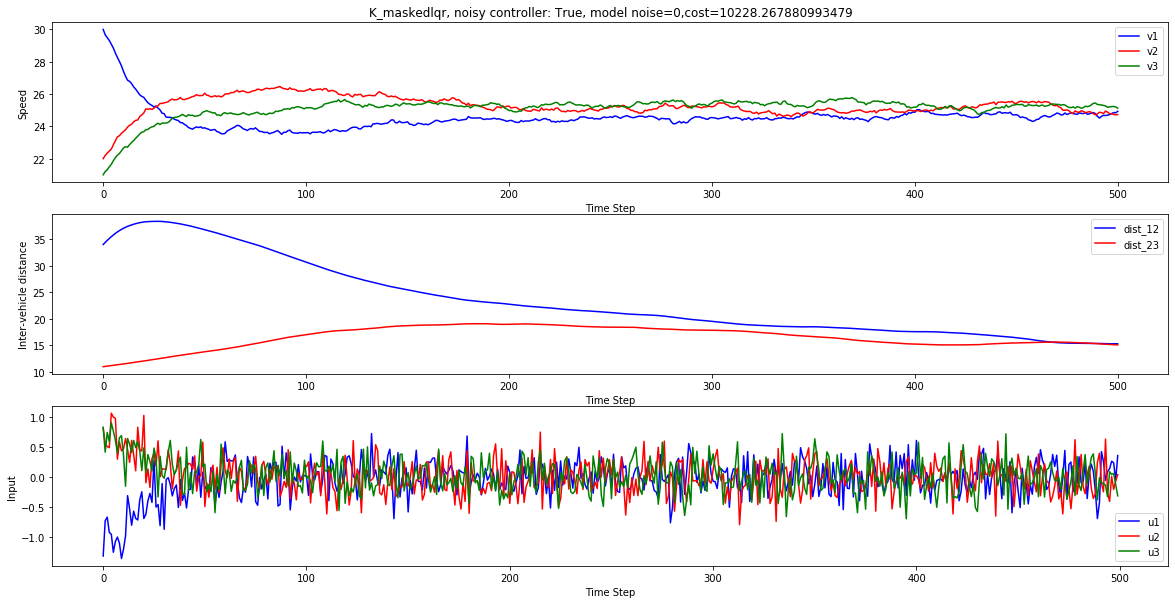

In [6]:
sys1 = ThreeVehicles(K_starter, noisy_controller=True, noisy_model=False) # no noise
X_initial = [5,24,-3,1,-4]

St,Co,In = sys1.RunEpisode(500,X_initial)
[v1,d12,v2,d23,v3] = sys1.ExtractStates(St)
u1,u2,u3 = sys1.ExtractInputs(In)
trajectory_cost = sys1.GetDiscountedCost(Co)

sys1.PlotResult(v1,v2,v3,d12,d23, u1, u2, u3,trajectory_cost,'Figure - K_maskedlqr','K_maskedlqr',noisy_controller=sys1.noisy_controller,model_noise=sys1.sigma_model)


## Collect graphs for report

#### Using:

    K_starter
    controller noise = 0.25
    New cost matrices
    500 transitions
    20 updates
    no constraints
    
We will find 20 improved controllers for a range of iteration numbers:

    20
    200
    2000
    10000

# DO NOT delete cells below - they contain all the data

    LoK
    LoC
    Thetas
    
    for all 4 of the above

In [301]:
LoK_20

[array([[-0.2 , -0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01, -0.2 , -0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01, -0.2 ]]),
 array([[-0.12861047, -0.02351263,  0.078223  , -0.00325698,  0.05288949],
        [ 0.04409125,  0.01619064, -0.09985417, -0.01026993,  0.05053807],
        [ 0.02531316, -0.00613132, -0.03047875,  0.01650496, -0.10337341]]),
 array([[-0.06134874, -0.0171337 ,  0.03173506, -0.01006599,  0.03375467],
        [ 0.03591196,  0.01525141, -0.06288716, -0.01914167,  0.02688563],
        [ 0.03195795,  0.00088286,  0.02064928,  0.02050697, -0.10183367]]),
 array([[-0.06215144, -0.0244341 ,  0.03847811, -0.0025388 ,  0.01633802],
        [ 0.06664739,  0.01916914, -0.09653708, -0.01651259,  0.04040291],
        [ 0.03759715,  0.00950087,  0.00974628,  0.01686882, -0.0576312 ]]),
 array([[-0.06416633, -0.01422989,  0.03589614, -0.00257905,  0.02217951],
        [ 0.03718546,  0.01761543, -0.08110848, -0.01028671,  0.03183602],
        [ 0.02261216,  0.0083978

In [111]:
Th_20

[array([[ 4.54998539e+01],
        [-1.73194704e+01],
        [-1.31756798e+00],
        [ 1.75321704e+01],
        [ 4.78723798e+00],
        [ 2.24061160e+01],
        [-1.01033201e+01],
        [-5.01971907e+00],
        [ 4.72423766e+01],
        [-1.04890086e+01],
        [-1.43366257e+01],
        [ 9.71267059e+00],
        [-1.41760556e+01],
        [ 2.08935865e+01],
        [ 6.72036178e+00],
        [ 4.47756556e+01],
        [ 5.15403536e+00],
        [-1.54310008e+01],
        [-8.25173988e+00],
        [-8.89489923e+00],
        [ 2.07116899e+01],
        [ 5.53121048e+00],
        [ 1.35810759e+00],
        [ 4.20921853e+00],
        [-3.39394000e+00],
        [ 1.23904509e+00],
        [ 5.41805627e+00],
        [ 4.05950076e-01],
        [ 1.90455977e+00],
        [-3.31176136e+00],
        [ 8.60845289e+01],
        [-8.36849947e+00],
        [ 4.17191890e+00],
        [ 1.00179009e+02],
        [ 7.62480177e+00],
        [ 1.03110091e+02],
        [ 7.24916192e+02]]),

In [100]:
LoC_20 # minimum of 3892 at iteration 4

[8432.73591343187,
 4970.068484967615,
 4151.053260596792,
 4192.6848371002325,
 3892.6085759725497,
 3957.0151725565347,
 3942.3841692192814,
 3980.7003553603613,
 4150.683066326182,
 4307.544244751822,
 4086.4828021553003,
 4129.5577890772565,
 4127.411002666163,
 4353.767791138265,
 4613.694312049054,
 4310.561333702482,
 4274.768950276952,
 4022.1581684497896,
 4081.9357400538697,
 4230.108856447915,
 4075.2248242052383]

In [115]:
LoC_200

[8432.73591343187,
 5561.555599773348,
 4126.630098001032,
 3904.440858109738,
 3850.402515295229,
 3859.334830783127,
 3855.3215026489033,
 3856.0221717656673,
 3854.105295100341,
 3850.497347834981,
 3845.319193739915,
 3847.89450291596,
 3846.772383485107,
 3861.9174373091205,
 3846.5484189576523,
 3856.3984828863863,
 3850.389606473901,
 3849.579083347129,
 3854.194240223784,
 3865.7542866203776,
 3858.1170257548824]

In [116]:
LoK_200

[array([[-0.2 , -0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01, -0.2 , -0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01, -0.2 ]]),
 array([[-0.11984904, -0.01469685,  0.00535643, -0.00036102,  0.00160494],
        [ 0.02586644,  0.01389004, -0.12767059, -0.01371914,  0.01760506],
        [ 0.00041474,  0.00210643,  0.02227954,  0.01803561, -0.12701427]]),
 array([[-0.07486292, -0.01875209,  0.03212555, -0.00202907,  0.01038064],
        [ 0.03294521,  0.01375172, -0.09355232, -0.0107686 ,  0.01830025],
        [ 0.01577637,  0.00374518,  0.02753927,  0.01710947, -0.08513415]]),
 array([[-0.06847278, -0.01607083,  0.03546597, -0.00528735,  0.01306736],
        [ 0.03306585,  0.01572238, -0.08512091, -0.01018817,  0.04177986],
        [ 0.01529408,  0.00297937,  0.03275291,  0.0183951 , -0.06603952]]),
 array([[-0.06055768, -0.01753545,  0.04940783, -0.00456629,  0.00757136],
        [ 0.03130763,  0.01630582, -0.07728401, -0.01287816,  0.03178383],
        [ 0.01970719,  0.0043574

In [118]:
Th_200

[array([[ 4.38151453e+01],
        [-1.07928460e+01],
        [-3.64995515e+00],
        [ 1.25256645e+01],
        [ 1.11002681e+00],
        [ 2.48252474e+01],
        [-5.70652316e+00],
        [ 1.69896678e-01],
        [ 5.02810243e+01],
        [-1.17273841e+01],
        [-1.18315582e+01],
        [ 1.17158085e+01],
        [-1.40835209e+00],
        [ 2.69968828e+01],
        [-4.31057137e+00],
        [ 4.53818865e+01],
        [-1.99860656e+00],
        [-1.51861424e+01],
        [ 7.55551341e-02],
        [-3.26220142e+00],
        [ 2.70936383e+01],
        [ 5.98668334e+00],
        [ 3.02188307e+00],
        [ 3.05794201e+00],
        [-2.97982178e+00],
        [-4.58220580e-01],
        [ 6.29865565e+00],
        [-3.86787093e-03],
        [ 2.84171568e+00],
        [-3.80551922e+00],
        [ 1.03375177e+02],
        [-1.84175802e+00],
        [ 2.95205825e+00],
        [ 1.06011193e+02],
        [ 3.68076996e+00],
        [ 1.06929627e+02],
        [ 4.61846479e+02]]),

In [150]:
LoC_2000

[8432.73591343187,
 5064.758168106078,
 4091.0951936770794,
 3864.341460929759,
 3834.490254628287,
 3832.5429997693614,
 3833.2460310777715,
 3832.536933872808,
 3833.182227790256,
 3835.081497825691,
 3832.8952211254787,
 3834.5041578076866,
 3832.451924825671,
 3832.173418684121,
 3834.4986204782826,
 3832.666187704939,
 3833.6566614993353,
 3832.9353129355854,
 3833.830270586856,
 3833.866849864053,
 3832.717775550293]

In [151]:
LoK_2000

[array([[-0.2 , -0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01, -0.2 , -0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01, -0.2 ]]),
 array([[-0.09949304, -0.01512546,  0.01128765, -0.00255156,  0.00121086],
        [ 0.01325261,  0.01349899, -0.11484915, -0.01286583,  0.01670925],
        [ 0.01194755,  0.00311663,  0.01069705,  0.01718001, -0.10841601]]),
 array([[-0.06969122, -0.01687297,  0.02727827, -0.00464029,  0.01238995],
        [ 0.02460882,  0.01595818, -0.08520245, -0.01238687,  0.02326541],
        [ 0.00948185,  0.00369708,  0.02339373,  0.01937023, -0.07721342]]),
 array([[-0.06179676, -0.016256  ,  0.0344596 , -0.00410318,  0.01491978],
        [ 0.03235599,  0.0161729 , -0.08509507, -0.01307314,  0.03568118],
        [ 0.01221283,  0.00407288,  0.03108703,  0.01934444, -0.06689505]]),
 array([[-0.05925924, -0.01555401,  0.03758008, -0.00326792,  0.016567  ],
        [ 0.03464536,  0.01618942, -0.07885724, -0.01179638,  0.03283612],
        [ 0.01842361,  0.0049819

In [152]:
Th_2000

[array([[ 4.36297855e+01],
        [-1.16579326e+01],
        [-2.89277378e+00],
        [ 1.33013712e+01],
        [ 2.07976168e+00],
        [ 2.06660532e+01],
        [-2.77433845e+00],
        [-2.47850702e+00],
        [ 4.89892125e+01],
        [-1.16727272e+01],
        [-1.18730218e+01],
        [ 1.08425570e+01],
        [-2.41697336e+00],
        [ 2.36759524e+01],
        [-2.41481885e+00],
        [ 4.51991836e+01],
        [-2.46918158e+00],
        [-1.48069578e+01],
        [-2.95474988e-01],
        [-3.65117332e+00],
        [ 2.22946382e+01],
        [ 6.00234923e+00],
        [ 2.29246559e+00],
        [ 3.15039186e+00],
        [-2.78382086e+00],
        [-6.21376194e-01],
        [ 6.06993673e+00],
        [ 5.29514375e-01],
        [ 2.68081680e+00],
        [-3.55404851e+00],
        [ 1.03779749e+02],
        [-6.93191772e-01],
        [-5.14063203e-01],
        [ 1.02949174e+02],
        [-1.95179833e+00],
        [ 1.02666585e+02],
        [ 5.30277982e+02]]),

In [298]:
LoC_10k

[8432.73591343187,
 5185.212791124979,
 4145.257443535989,
 3864.328724893335,
 3831.6326280520625,
 3831.2539293196733,
 3831.206436116564,
 3831.510628562244,
 3831.2947153380996,
 3831.2534365363636,
 3831.479307079374,
 3831.604335841792,
 3831.197533741991,
 3831.522163805878,
 3831.216938956549,
 3831.3597577846613,
 3831.589143996713,
 3831.648107230818,
 3831.423947472445,
 3831.550892017041,
 3831.4648782693853]

In [299]:
LoK_10k

[array([[-0.2 , -0.01,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  0.01, -0.2 , -0.01,  0.  ],
        [ 0.  ,  0.  ,  0.  ,  0.01, -0.2 ]]),
 array([[-0.10822758, -0.01558245,  0.01281579, -0.00264695,  0.00150189],
        [ 0.01467792,  0.01454796, -0.11825135, -0.01276499,  0.01523949],
        [ 0.00392247,  0.00304041,  0.0117633 ,  0.01693159, -0.10562958]]),
 array([[-0.07023586, -0.01633224,  0.02561351, -0.00350749,  0.00929505],
        [ 0.02448074,  0.01566494, -0.09076951, -0.01237167,  0.02327651],
        [ 0.01013111,  0.0042115 ,  0.02496421,  0.01946516, -0.07753124]]),
 array([[-0.05961318, -0.01598452,  0.03411854, -0.00331992,  0.01383841],
        [ 0.03294254,  0.01548415, -0.08228532, -0.01190271,  0.03026634],
        [ 0.01439013,  0.00469989,  0.03105276,  0.01970914, -0.07055411]]),
 array([[-0.05635087, -0.0161156 ,  0.03579322, -0.00362127,  0.01629158],
        [ 0.03597399,  0.0159431 , -0.08071934, -0.01182439,  0.0320877 ],
        [ 0.01631702,  0.0045467

In [300]:
Th_10k

[array([[ 4.41740572e+01],
        [-1.13899293e+01],
        [-2.35124889e+00],
        [ 1.34886162e+01],
        [ 2.35223767e+00],
        [ 2.22606658e+01],
        [-3.14194816e+00],
        [-8.54879509e-01],
        [ 4.91847826e+01],
        [-1.13466495e+01],
        [-1.23560825e+01],
        [ 1.10006518e+01],
        [-2.75368051e+00],
        [ 2.44172992e+01],
        [-2.45965760e+00],
        [ 4.46491025e+01],
        [-2.54085264e+00],
        [-1.47247124e+01],
        [-3.50736489e-01],
        [-3.19616244e+00],
        [ 2.16204990e+01],
        [ 5.97744657e+00],
        [ 2.31404132e+00],
        [ 3.21970679e+00],
        [-3.01663940e+00],
        [-6.23303458e-01],
        [ 6.01247605e+00],
        [ 5.39718906e-01],
        [ 2.63943267e+00],
        [-3.47215889e+00],
        [ 1.02759499e+02],
        [-1.06797843e+00],
        [-5.52349168e-01],
        [ 1.03160126e+02],
        [-5.06979023e-01],
        [ 1.02300624e+02],
        [ 5.41766152e+02]]),

# Now plot some results

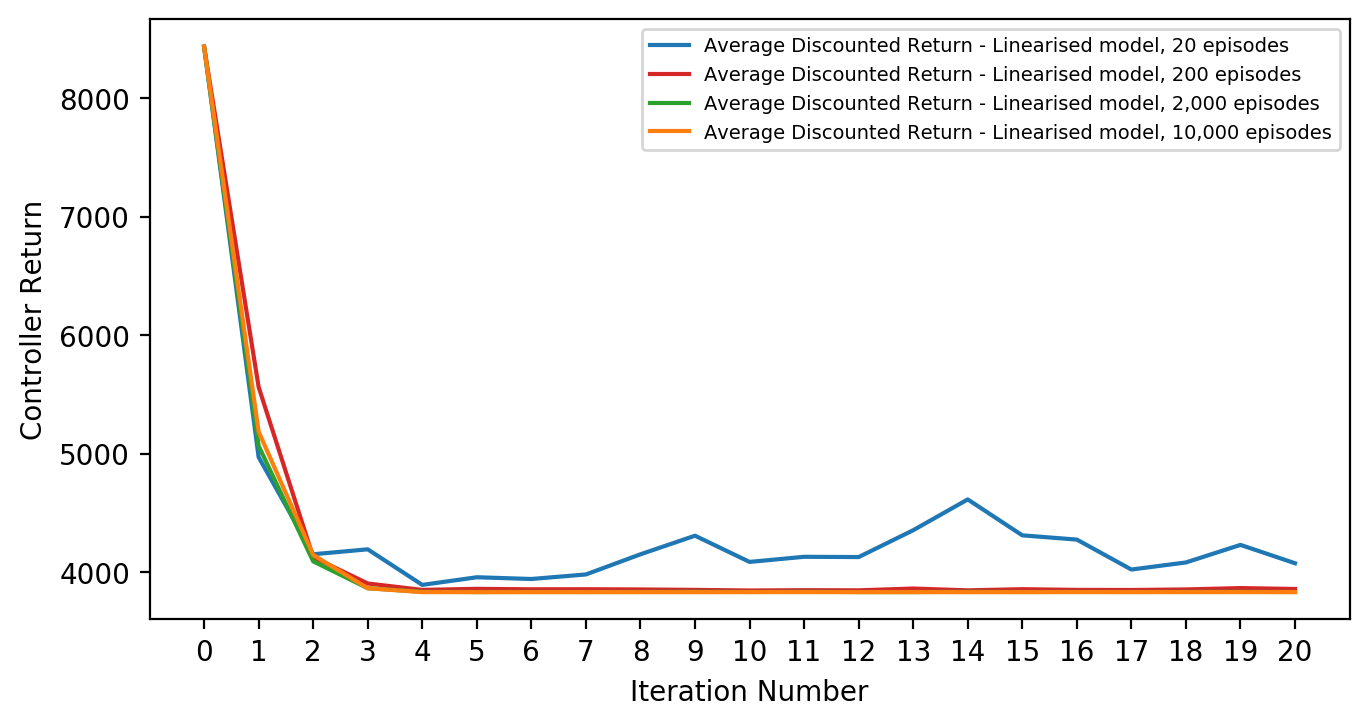

In [317]:
PlotAverageCosts(LoC1=LoC_20,LoC2=LoC_200,LoC3=LoC_2000,LoC4=LoC_10k, figname='zoomed out average return plot - linearised (updated cost function)') #, save= True)

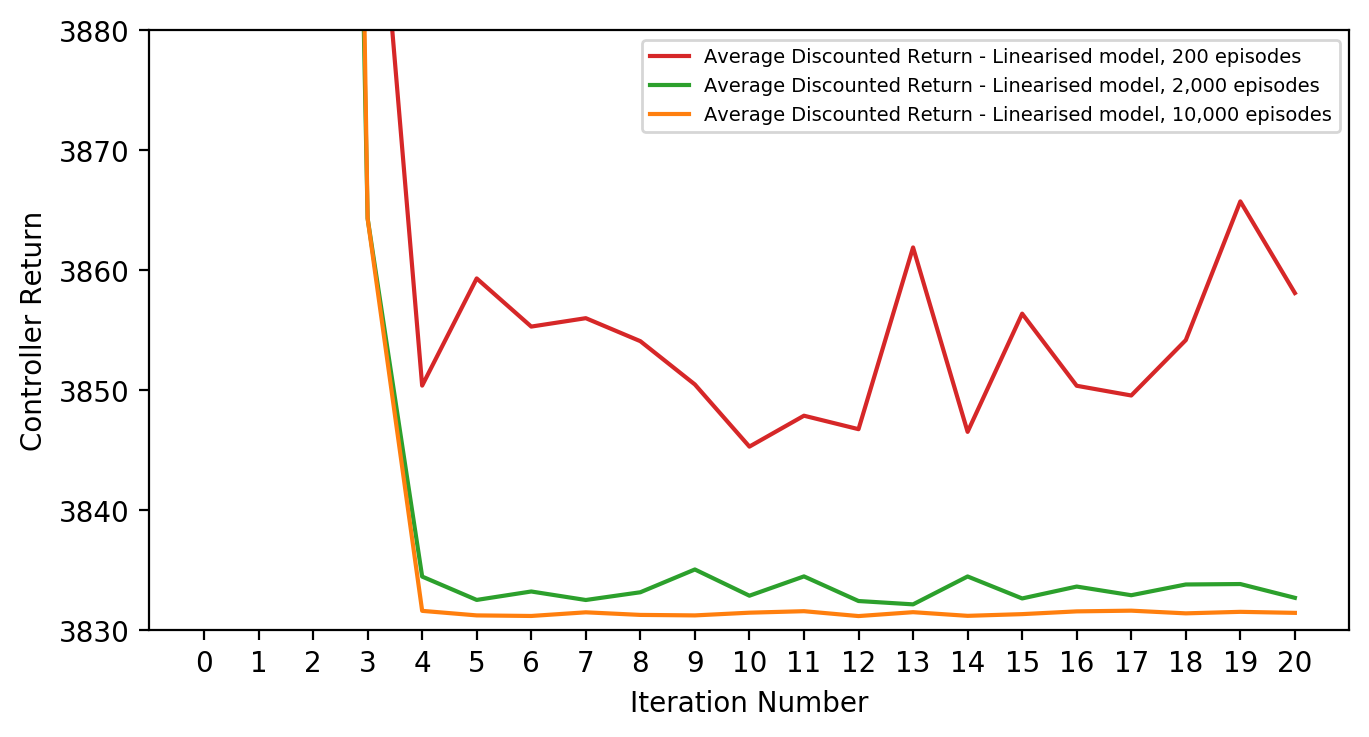

In [318]:
PlotAverageCosts(LoC2=LoC_200,LoC3=LoC_2000,LoC4=LoC_10k,zoom=[3830,3880], figname='zoomed in average return plot - linearised (updated cost function)') #, save= True)